In [0]:
%cd MesoNet/

/content/gdrive/My Drive/MesoNet


In [0]:
!ls

classifiers.py		 FaceExtraction  pipeline.py  test_images   weights
example.py		 LICENSE	 __pycache__  test_videos
extractFaceFromVideo.py  NOTICE		 README.md    train_images


In [0]:
""" MesoNet Architecture
"""
from keras.models import Model as KerasModel
from keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Reshape, Concatenate, LeakyReLU
from keras.optimizers import Adam

IMGWIDTH = 256

class Classifier:
    def __init__():
        self.model = 0
    
    def predict(self, x):
        return self.model.predict(x)
    
    def fit(self, x, y):
        return self.model.train_on_batch(x, y)
    
    def get_accuracy(self, x, y):
        return self.model.test_on_batch(x, y)
    
    def load(self, path):
        self.model.load_weights(path)


class Meso1(Classifier):
    """
    Feature extraction + Classification
    """
    def __init__(self, learning_rate = 0.001, dl_rate = 1):
        self.model = self.init_model(dl_rate)
        optimizer = Adam(lr = learning_rate)
        self.model.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = ['accuracy'])
    
    def init_model(self, dl_rate):
        x = Input(shape = (IMGWIDTH, IMGWIDTH, 3))
        
        x1 = Conv2D(16, (3, 3), dilation_rate = dl_rate, strides = 1, padding='same', activation = 'relu')(x)
        x1 = Conv2D(4, (1, 1), padding='same', activation = 'relu')(x1)
        x1 = BatchNormalization()(x1)
        x1 = MaxPooling2D(pool_size=(8, 8), padding='same')(x1)

        y = Flatten()(x1)
        y = Dropout(0.5)(y)
        y = Dense(1, activation = 'sigmoid')(y)
        return KerasModel(inputs = x, outputs = y)


class Meso4(Classifier):
    def __init__(self, learning_rate = 0.001):
        self.model = self.init_model()
        optimizer = Adam(lr = learning_rate)
        self.model.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = ['accuracy'])
    
    def init_model(self): 
        x = Input(shape = (IMGWIDTH, IMGWIDTH, 3))
        
        x1 = Conv2D(8, (3, 3), padding='same', activation = 'relu')(x)
        x1 = BatchNormalization()(x1)
        x1 = MaxPooling2D(pool_size=(2, 2), padding='same')(x1)
        
        x2 = Conv2D(8, (5, 5), padding='same', activation = 'relu')(x1)
        x2 = BatchNormalization()(x2)
        x2 = MaxPooling2D(pool_size=(2, 2), padding='same')(x2)
        
        x3 = Conv2D(16, (5, 5), padding='same', activation = 'relu')(x2)
        x3 = BatchNormalization()(x3)
        x3 = MaxPooling2D(pool_size=(2, 2), padding='same')(x3)
        
        x4 = Conv2D(16, (5, 5), padding='same', activation = 'relu')(x3)
        x4 = BatchNormalization()(x4)
        x4 = MaxPooling2D(pool_size=(4, 4), padding='same')(x4)
        
        y = Flatten()(x4)
        y = Dropout(0.5)(y)
        y = Dense(16)(y)
        y = LeakyReLU(alpha=0.1)(y)
        y = Dropout(0.5)(y)
        y = Dense(1, activation = 'sigmoid')(y)

        return KerasModel(inputs = x, outputs = y)


class MesoInception4(Classifier):
    def __init__(self, learning_rate = 0.001):
        self.model = self.init_model()
        optimizer = Adam(lr = learning_rate)
        self.model.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = ['accuracy'])
    
    def InceptionLayer(self, a, b, c, d):
        def func(x):
            x1 = Conv2D(a, (1, 1), padding='same', activation='relu')(x)
            
            x2 = Conv2D(b, (1, 1), padding='same', activation='relu')(x)
            x2 = Conv2D(b, (3, 3), padding='same', activation='relu')(x2)
            
            x3 = Conv2D(c, (1, 1), padding='same', activation='relu')(x)
            x3 = Conv2D(c, (3, 3), dilation_rate = 2, strides = 1, padding='same', activation='relu')(x3)
            
            x4 = Conv2D(d, (1, 1), padding='same', activation='relu')(x)
            x4 = Conv2D(d, (3, 3), dilation_rate = 3, strides = 1, padding='same', activation='relu')(x4)

            y = Concatenate(axis = -1)([x1, x2, x3, x4])
            
            return y
        return func
    
    def init_model(self):
        x = Input(shape = (IMGWIDTH, IMGWIDTH, 3))
        
        x1 = self.InceptionLayer(1, 4, 4, 2)(x)
        x1 = BatchNormalization()(x1)
        x1 = MaxPooling2D(pool_size=(2, 2), padding='same')(x1)
        
        x2 = self.InceptionLayer(2, 4, 4, 2)(x1)
        x2 = BatchNormalization()(x2)
        x2 = MaxPooling2D(pool_size=(2, 2), padding='same')(x2)        
        
        x3 = Conv2D(16, (5, 5), padding='same', activation = 'relu')(x2)
        x3 = BatchNormalization()(x3)
        x3 = MaxPooling2D(pool_size=(2, 2), padding='same')(x3)
        
        x4 = Conv2D(16, (5, 5), padding='same', activation = 'relu')(x3)
        x4 = BatchNormalization()(x4)
        x4 = MaxPooling2D(pool_size=(4, 4), padding='same')(x4)
        
        y = Flatten()(x4)
        y = Dropout(0.5)(y)
        y = Dense(16)(y)
        y = LeakyReLU(alpha=0.1)(y)
        y = Dropout(0.5)(y)
        y = Dense(1, activation = 'sigmoid')(y)

        return KerasModel(inputs = x, outputs = y)

Using TensorFlow backend.


In [0]:
"""For Detection in videos, frames need to be processed
"""

import random
from os import listdir
from os.path import isfile, join

import numpy as np
from math import floor
from scipy.ndimage.interpolation import zoom, rotate

import imageio
import face_recognition


## Face extraction

class Video:
    def __init__(self, path):
        self.path = path
        self.container = imageio.get_reader(path, 'ffmpeg')
        self.length = self.container.count_frames()
        self.fps = self.container.get_meta_data()['fps']
    
    def init_head(self):
        self.container.set_image_index(0)
    
    def next_frame(self):
        self.container.get_next_data()
    
    def get(self, key):
        return self.container.get_data(key)
    
    def __call__(self, key):
        return self.get(key)
    
    def __len__(self):
        return self.length


class FaceFinder(Video):
    def __init__(self, path, load_first_face = True):
        super().__init__(path)
        self.faces = {}
        self.coordinates = {}  # stores the face (locations center, rotation, length)
        self.last_frame = self.get(0)
        self.frame_shape = self.last_frame.shape[:2]
        self.last_location = (0, 200, 200, 0)
        if (load_first_face):
            face_positions = face_recognition.face_locations(self.last_frame, number_of_times_to_upsample=2)
            if len(face_positions) > 0:
                self.last_location = face_positions[0]
    
    def load_coordinates(self, filename):
        np_coords = np.load(filename)
        self.coordinates = np_coords.item()
    
    def expand_location_zone(self, loc, margin = 0.2):
        ''' Adds a margin around a frame slice '''
        offset = round(margin * (loc[2] - loc[0]))
        y0 = max(loc[0] - offset, 0)
        x1 = min(loc[1] + offset, self.frame_shape[1])
        y1 = min(loc[2] + offset, self.frame_shape[0])
        x0 = max(loc[3] - offset, 0)
        return (y0, x1, y1, x0)
    
    @staticmethod
    def upsample_location(reduced_location, upsampled_origin, factor):
        ''' Adapt a location to an upsampled image slice '''
        y0, x1, y1, x0 = reduced_location
        Y0 = round(upsampled_origin[0] + y0 * factor)
        X1 = round(upsampled_origin[1] + x1 * factor)
        Y1 = round(upsampled_origin[0] + y1 * factor)
        X0 = round(upsampled_origin[1] + x0 * factor)
        return (Y0, X1, Y1, X0)

    @staticmethod
    def pop_largest_location(location_list):
        max_location = location_list[0]
        max_size = 0
        if len(location_list) > 1:
            for location in location_list:
                size = location[2] - location[0]
                if size > max_size:
                    max_size = size
                    max_location = location
        return max_location
    
    @staticmethod
    def L2(A, B):
        return np.sqrt(np.sum(np.square(A - B)))
    
    def find_coordinates(self, landmark, K = 2.2):
        '''
        We either choose K * distance(eyes, mouth),
        or, if the head is tilted, K * distance(eye 1, eye 2)
        /!\ landmarks coordinates are in (x,y) not (y,x)
        '''
        E1 = np.mean(landmark['left_eye'], axis=0)
        E2 = np.mean(landmark['right_eye'], axis=0)
        E = (E1 + E2) / 2
        N = np.mean(landmark['nose_tip'], axis=0) / 2 + np.mean(landmark['nose_bridge'], axis=0) / 2
        B1 = np.mean(landmark['top_lip'], axis=0)
        B2 = np.mean(landmark['bottom_lip'], axis=0)
        B = (B1 + B2) / 2

        C = N
        l1 = self.L2(E1, E2)
        l2 = self.L2(B, E)
        l = max(l1, l2) * K
        if (B[1] == E[1]):
            if (B[0] > E[0]):
                rot = 90
            else:
                rot = -90
        else:
            rot = np.arctan((B[0] - E[0]) / (B[1] - E[1])) / np.pi * 180
        
        return ((floor(C[1]), floor(C[0])), floor(l), rot)
    
    
    def find_faces(self, resize = 0.5, stop = 0, skipstep = 0, no_face_acceleration_threshold = 3, cut_left = 0, cut_right = -1, use_frameset = False, frameset = []):
        '''
        The core function to extract faces from frames
        using previous frame location and downsampling to accelerate the loop.
        '''
        not_found = 0
        no_face = 0
        no_face_acc = 0
        
        # to only deal with a subset of a video, for instance I-frames only
        if (use_frameset):
            finder_frameset = frameset
        else:
            if (stop != 0):
                finder_frameset = range(0, min(self.length, stop), skipstep + 1)
            else:
                finder_frameset = range(0, self.length, skipstep + 1)
        
        # Quick face finder loop
        for i in finder_frameset:
            # Get frame
            frame = self.get(i)
            if (cut_left != 0 or cut_right != -1):
                frame[:, :cut_left] = 0
                frame[:, cut_right:] = 0            
            
            # Find face in the previously found zone
            potential_location = self.expand_location_zone(self.last_location)
            potential_face_patch = frame[potential_location[0]:potential_location[2], potential_location[3]:potential_location[1]]
            potential_face_patch_origin = (potential_location[0], potential_location[3])
    
            reduced_potential_face_patch = zoom(potential_face_patch, (resize, resize, 1))
            reduced_face_locations = face_recognition.face_locations(reduced_potential_face_patch, model = 'cnn') # Here model = 'cnn' gives an TypeError, hence argument not required
            
            if len(reduced_face_locations) > 0:
                no_face_acc = 0  # reset the no_face_acceleration mode accumulator

                reduced_face_location = self.pop_largest_location(reduced_face_locations)
                face_location = self.upsample_location(reduced_face_location,
                                                    potential_face_patch_origin,
                                                    1 / resize)
                self.faces[i] = face_location
                self.last_location = face_location
                
                # extract face rotation, length and center from landmarks
                landmarks = face_recognition.face_landmarks(frame, [face_location])
                if len(landmarks) > 0:
                    # we assume that there is one and only one landmark group
                    self.coordinates[i] = self.find_coordinates(landmarks[0])
            else:
                not_found += 1

                if no_face_acc < no_face_acceleration_threshold:
                    # Look for face in full frame
                    face_locations = face_recognition.face_locations(frame, number_of_times_to_upsample = 2)
                else:
                    # Avoid spending to much time on a long scene without faces
                    reduced_frame = zoom(frame, (resize, resize, 1))
                    face_locations = face_recognition.face_locations(reduced_frame)
                    
                if len(face_locations) > 0:
                    print('Face extraction warning : ', i, '- found face in full frame', face_locations)
                    no_face_acc = 0  # reset the no_face_acceleration mode accumulator
                    
                    face_location = self.pop_largest_location(face_locations)
                    
                    # if was found on a reduced frame, upsample location
                    if no_face_acc > no_face_acceleration_threshold:
                        face_location = self.upsample_location(face_location, (0, 0), 1 / resize)
                    
                    self.faces[i] = face_location
                    self.last_location = face_location
                    
                    # extract face rotation, length and center from landmarks
                    landmarks = face_recognition.face_landmarks(frame, [face_location])
                    if len(landmarks) > 0:
                        self.coordinates[i] = self.find_coordinates(landmarks[0])
                else:
                    print('Face extraction warning : ',i, '- no face')
                    no_face_acc += 1
                    no_face += 1

        print('Face extraction report of', 'not_found :', not_found)
        print('Face extraction report of', 'no_face :', no_face)
        return 0
    
    def get_face(self, i):
        ''' Basic unused face extraction without alignment '''
        frame = self.get(i)
        if i in self.faces:
            loc = self.faces[i]
            patch = frame[loc[0]:loc[2], loc[3]:loc[1]]
            return patch
        return frame
    
    @staticmethod
    def get_image_slice(img, y0, y1, x0, x1):
        '''Get values outside the domain of an image'''
        m, n = img.shape[:2]
        padding = max(-y0, y1-m, -x0, x1-n, 0)
        padded_img = np.pad(img, ((padding, padding), (padding, padding), (0, 0)), 'reflect')
        return padded_img[(padding + y0):(padding + y1),
                        (padding + x0):(padding + x1)]
    
    def get_aligned_face(self, i, l_factor = 1.3):
        '''
        The second core function that converts the data from self.coordinates into an face image.
        '''
        frame = self.get(i)
        if i in self.coordinates:
            c, l, r = self.coordinates[i]
            l = int(l) * l_factor # fine-tuning the face zoom we really want
            dl_ = floor(np.sqrt(2) * l / 2) # largest zone even when rotated
            patch = self.get_image_slice(frame,
                                    floor(c[0] - dl_),
                                    floor(c[0] + dl_),
                                    floor(c[1] - dl_),
                                    floor(c[1] + dl_))
            rotated_patch = rotate(patch, -r, reshape=False)
            # note : dl_ is the center of the patch of length 2dl_
            return self.get_image_slice(rotated_patch,
                                    floor(dl_-l//2),
                                    floor(dl_+l//2),
                                    floor(dl_-l//2),
                                    floor(dl_+l//2))
        return frame


## Face prediction

class FaceBatchGenerator:
    '''
    Made to deal with framesubsets of video.
    '''
    def __init__(self, face_finder, target_size = 256):
        self.finder = face_finder
        self.target_size = target_size
        self.head = 0
        self.length = int(face_finder.length)

    def resize_patch(self, patch):
        m, n = patch.shape[:2]
        return zoom(patch, (self.target_size / m, self.target_size / n, 1))
    
    def next_batch(self, batch_size = 50):
        batch = np.zeros((1, self.target_size, self.target_size, 3))
        stop = min(self.head + batch_size, self.length)
        i = 0
        while (i < batch_size) and (self.head < self.length):
            if self.head in self.finder.coordinates:
                patch = self.finder.get_aligned_face(self.head)
                batch = np.concatenate((batch, np.expand_dims(self.resize_patch(patch), axis = 0)),
                                        axis = 0)
                i += 1
            self.head += 1
        return batch[1:]


def predict_faces(generator, classifier, batch_size = 50, output_size = 1):
    '''
    Compute predictions for a face batch generator
    '''
    n = len(generator.finder.coordinates.items())
    profile = np.zeros((1, output_size))
    for epoch in range(n // batch_size + 1):
        face_batch = generator.next_batch(batch_size = batch_size)
        prediction = classifier.predict(face_batch)
        if (len(prediction) > 0):
            profile = np.concatenate((profile, prediction))
    return profile[1:]


def compute_accuracy(classifier, dirname, frame_subsample_count = 30):
    '''
    Extraction + Prediction over a video
    '''
    filenames = [f for f in listdir(dirname) if isfile(join(dirname, f)) and ((f[-4:] == '.mp4') or (f[-4:] == '.avi') or (f[-4:] == '.mov'))]
    predictions = {}
    
    for vid in filenames:
        print('Dealing with video ', vid)
        
        # Compute face locations and store them in the face finder
        face_finder = FaceFinder(join(dirname, vid), load_first_face = False)
        skipstep = max(floor(face_finder.length / frame_subsample_count), 0)
        face_finder.find_faces(resize=0.5, skipstep = skipstep)
        
        print('Predicting ', vid)
        gen = FaceBatchGenerator(face_finder)
        p = predict_faces(gen, classifier)
        
        predictions[vid[:-4]] = (np.mean(p > 0.5), p)
    return predictions

In [0]:
!pip install mtcnn

     |████████████████████████████████| 2.3MB 2.8MB/s 


In [0]:
! python extractFaceFromVideo.py

['/content/gdrive/My Drive/MesoNet/MesoNet/test_videos/test_video_1.mp4']
Using TensorFlow backend.







2020-03-10 08:04:54.591584: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2200000000 Hz
2020-03-10 08:04:54.591831: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x1ea32c0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2020-03-10 08:04:54.591865: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2020-03-10 08:04:54.593788: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-03-10 08:04:54.641196: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-03-10 08:04:54.642048: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x6b97500 

In [0]:
import os
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import cv2
plt.style.use('ggplot')

#metadata_file_df = pd.read_json('train_sample_videos/metadata.json').T
#print(metadata_file_df.head())

#stats = metadata_file_df.groupby('label').size()
#stats.plot(figsize = (15,5), kind = 'bar', label = 'Information extracted from JSON Metadata file')

train_dir = '/content/gdrive/My Drive/MesoNet/MesoNet/test_videos/'
# preparing a list of training videos
train_video_files = [train_dir + i for i in os.listdir(train_dir)]
print(train_video_files)

['/content/gdrive/My Drive/MesoNet/MesoNet/test_videos/tbbt.mp4', '/content/gdrive/My Drive/MesoNet/MesoNet/test_videos/friends.mp4', '/content/gdrive/My Drive/MesoNet/MesoNet/test_videos/aassnaulhq.mp4']


[{'box': [833, 145, 135, 165], 'confidence': 0.9789633750915527, 'keypoints': {'left_eye': (873, 198), 'right_eye': (932, 201), 'nose': (894, 209), 'mouth_left': (870, 256), 'mouth_right': (917, 260)}}, {'box': [518, 260, 272, 358], 'confidence': 0.7388896346092224, 'keypoints': {'left_eye': (612, 400), 'right_eye': (716, 386), 'nose': (666, 446), 'mouth_left': (622, 528), 'mouth_right': (708, 514)}}]
2


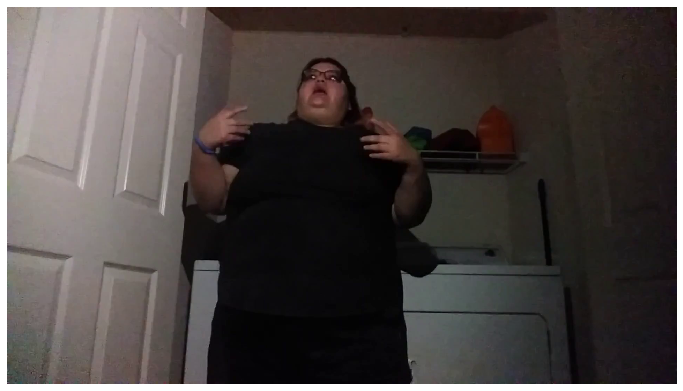

In [0]:
from mtcnn.mtcnn import MTCNN
detector = MTCNN()
v_cap = cv2.VideoCapture(train_video_files[2])
_, frame = v_cap.read()
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(frame, cmap = 'gray')
plt.axis('off')

result = detector.detect_faces(frame)
print(result)
print(len(result))

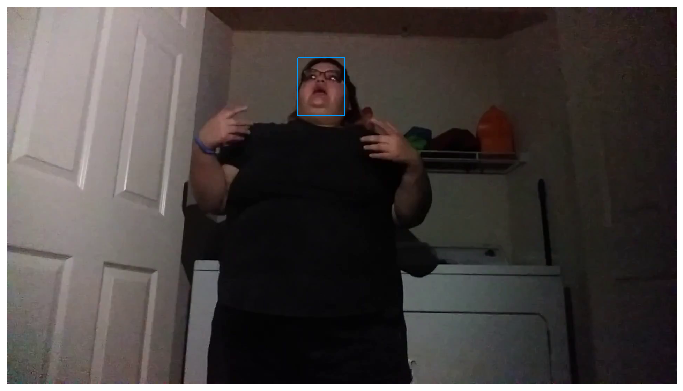

(165, 135, 3)
(128, 128, 3)


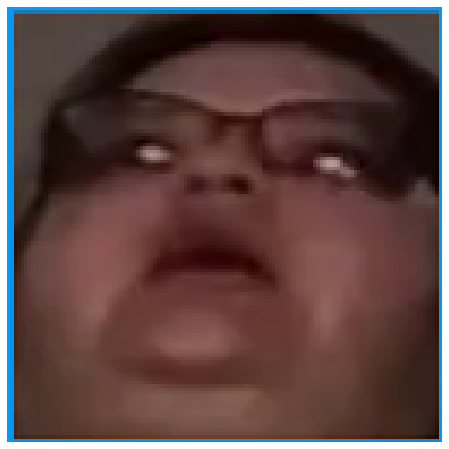

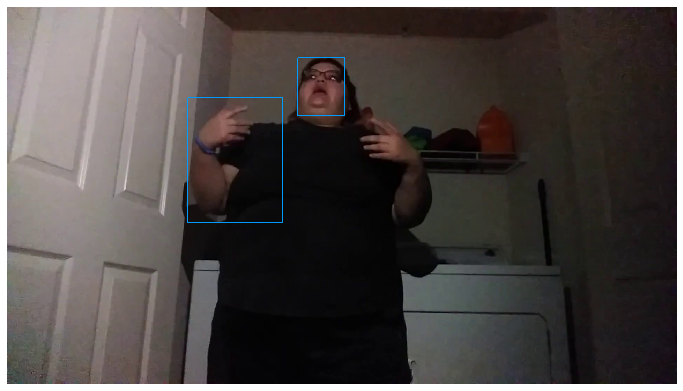

(358, 272, 3)
(128, 128, 3)


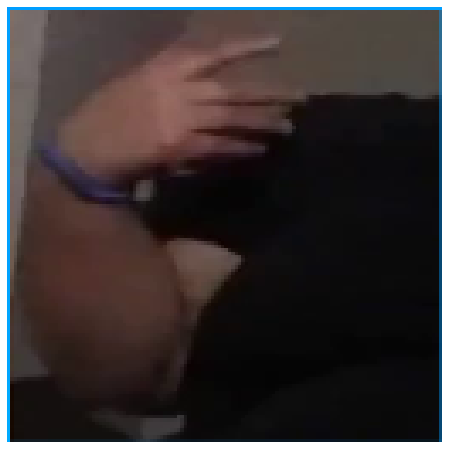

In [0]:
def img_enhancement(image):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    hist_equalized_image = clahe.apply(image) # Adaptive Histogram equalization 
    # hist_equalized_image = cv2.equalizeHist(image) # Global Histogram Equalization
    return(hist_equalized_image)

"""
The grayscale conversion was done correctly. The problem is in how you are displaying the image.
By default imshow adds it's own colour key to single channel images, to make it easier to view. 
"""
import os
from PIL import Image
for j in range(len(result)):
    bounding_box = result[j]['box']
    cv2.rectangle(frame,
              (bounding_box[0], bounding_box[1]),
              (bounding_box[0]+bounding_box[2], bounding_box[1] + bounding_box[3]),
              (0,155,255),
              2)
    plt.figure(figsize=(12, 8)) # as cv2.imshow crashes the Jupyter notebook
    plt.imshow(frame)
    plt.axis("off")
    plt.show()
    frame_cropped = frame[bounding_box[1] : bounding_box[1] + bounding_box[3], bounding_box[0] : bounding_box[0] + bounding_box[2]]
    plt.figure(figsize=(12, 8)) # as cv2.imshow crashes the Jupyter notebook
    im = frame_cropped #cv2.cvtColor(frame_cropped,cv2.COLOR_RGB2GRAY)
    
    #im = img_enhancement(im) 

    print(im.shape)
    previous_size_im = im
    new_size_im = cv2.resize(previous_size_im,(128,128),interpolation=cv2.INTER_CUBIC )
    plt.imshow(new_size_im)

    """ The new_size_im contains the preprossessed face captured from the video frame. It's type is numpy array 
        so to save this as an image we use PIL. This new_size_im will be saved as a jpeg file in the test folder 
        specified through it's location in the directory variable. 
    """
    directory = '/content/gdrive/My Drive/MesoNet/MesoNet/test_images/test_folder/' 
    os.chdir(directory)
    
    saved_image = Image.fromarray(new_size_im)
    saved_image.save("your_file" + str(j) + ".jpeg")
    print(new_size_im.shape)
    plt.axis("off")
    plt.show()

In [0]:
!ls

143_69.jpg  143_80.jpg	143_93.jpg  144_48.jpg	144_82.jpg
143_71.jpg  143_81.jpg	143_94.jpg  144_50.jpg	IMG_20170722_095355.jpg
143_72.jpg  143_82.jpg	143_98.jpg  144_52.jpg	your_file0.jpeg
143_75.jpg  143_84.jpg	144_24.jpg  144_58.jpg	your_file1.jpeg
143_76.jpg  143_86.jpg	144_26.jpg  144_64.jpg
143_77.jpg  143_88.jpg	144_30.jpg  144_66.jpg
143_78.jpg  143_89.jpg	144_38.jpg  144_74.jpg
143_79.jpg  143_91.jpg	144_40.jpg  144_80.jpg


In [0]:
%cd /content/gdrive/My Drive/MesoNet/MesoNet/

/content/gdrive/My Drive/MesoNet/MesoNet


In [0]:
%cd ..

/content/gdrive/My Drive/MesoNet/MesoNet


In [0]:
!ls

classifiers.py		 FaceExtraction  pipeline.py  test_images   weights
example.py		 LICENSE	 __pycache__  test_videos
extractFaceFromVideo.py  NOTICE		 README.md    train_images


In [0]:
MesoNet_classifier = Meso4()



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



In [0]:
MesoNet_classifier.load("weights/Meso4_DF")

In [0]:
from keras.preprocessing.image import ImageDataGenerator

In [0]:
image_data_generator = ImageDataGenerator(rescale=1.0/255)
data_generator = image_data_generator.flow_from_directory("",classes=["test_images"]) 

""" Here test_images folder will contain another dolder having any name
    That folder will contain all the test images we will work on
"""

Found 36 images belonging to 1 classes.


' Here test_images folder will contain another dolder having any name\n    That folder will contain all the test images we will work on\n'

In [0]:
num_to_label = {1: "real" , 0:"fake"}

In [0]:
X,y = data_generator.next()

In [0]:
probablistic_predictions = MesoNet_classifier.predict(X)

In [0]:
print(probablistic_predictions)

[[3.63546014e-02]
 [3.76674026e-01]
 [1.04635954e-04]
 [8.32990408e-02]
 [2.15640962e-02]
 [6.06720448e-02]
 [3.71895432e-02]
 [1.63167119e-02]
 [5.88779271e-01]
 [9.99990225e-01]
 [3.26712430e-01]
 [3.43197405e-01]
 [5.40426672e-02]
 [2.95922160e-02]
 [1.94241107e-02]
 [1.25228584e-01]
 [4.27418709e-01]
 [4.27957833e-01]
 [5.24526834e-03]
 [2.47091711e-01]
 [3.27334851e-01]
 [6.57319725e-02]
 [5.34089208e-02]
 [8.36349726e-02]
 [7.04782903e-02]
 [3.62944305e-02]
 [2.61911750e-03]
 [8.11594725e-03]
 [2.32802391e-01]
 [6.24820292e-02]
 [6.28100932e-02]
 [2.61273444e-01]]


In [0]:
probablistic_predictions[0][0]

0.008115947

In [0]:
predictions = [ num_to_label[round(x[0],0)] for x in probablistic_predictions]

In [0]:
print(predictions)

['fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'real', 'real', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake']


In [ ]:
"""For using the pipeline directly on a test video use the following code
   
   predictions = compute_accuracy(classifier, '/MesoNet/test_videos')
   for video_name in predictions:
        print('`{}` video class prediction :'.format(video_name), predictions[video_name][0])

"""